In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/houston_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);

VV = _load_jld(VV_files[[1,3]],data_folder);
VH = _load_jld(VH_files[[1,3]],data_folder);

In [3]:

data_folder = "/Users/simon/Documents/DTU fag/Speciale/houston_new/flood"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre.jld"),"data")];


In [4]:
threshold_indx = 3

3

## VV

In [5]:
co = VV[1][:,end:-1:1]
pre = VV[2][:,end:-1:1];

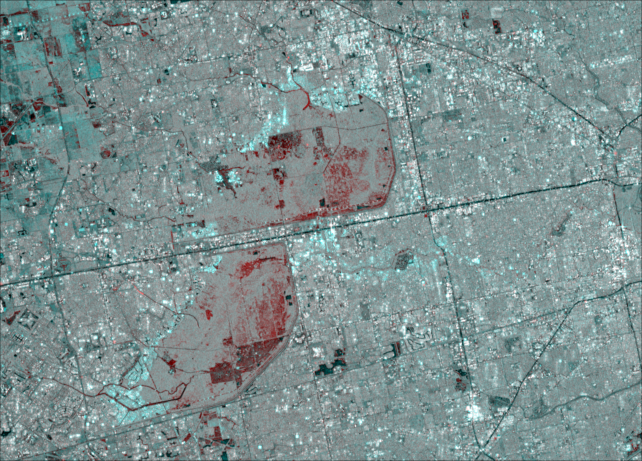

In [6]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [7]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [8]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


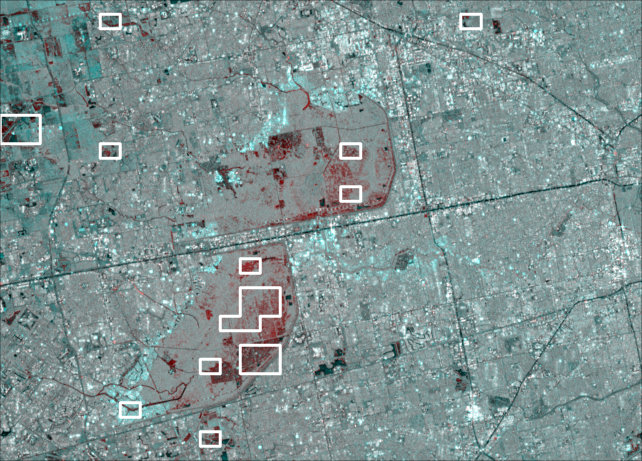

In [9]:
subset_edges = get_edges(bm_mask);
add_mask(imgVV,subset_edges,(1,1,1))

In [10]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;



In [11]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-12.85, -1.0], f_i: 0.000744157336115509
dfdx: [-0.00364623, 0.0]
Step x, step_idx:3,  no_step: -2

Iterration : 2
x_i: [23.6123, -1.0], f_i: 0.00015478232329040943
dfdx: [0.0, 7.09001e-5]
No change, Decrease delta, no_step: -1

Iterration : 3
x_i: [23.6123, -1.0], f_i: 0.00015478232329040943
dfdx: [0.0, 0.000146015]
No change, Decrease delta, no_step: 0

Iterration : 4
x_i: [23.6123, -1.0], f_i: 0.00015478232329040943
dfdx: [0.0, 0.0]

Iterration : 5
x_i: [23.6123, -1.0], f_i: 0.00015478232329040943
dfdx: [0.0, 0.000146015]
No change, Decrease delta, no_step: 1

Iterration : 6
x_i: [23.6123, -1.0], f_i: 0.00015478232329040943
dfdx: [0.0, 0.0]

Iterration : 7
x_i: [23.6123, -1.0], f_i: 0.00015478232329040943
dfdx: [0.0, 0.000146015]
No change, Decrease delta, no_step: 2

Iterration : 8
x_i: [23.6123, -1.0], f_i: 0.00015478232329040943
dfdx: [0.0, 0.0]

Iterration : 9
x_i: [23.6123, -1.0], f_i: 0.00015478232329040943
dfdx: [0.0, 0.000146015]
No change, Decrease del

In [12]:
thresholds3, f3

([23.6123, -1.0], 0.00015478232329040943)

In [13]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-3.1966, -0.874097], 0.0001501592830773457)

In [14]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-11.5499, 1.44991], 0.00022808168249168528)

In [15]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [16]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [17]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

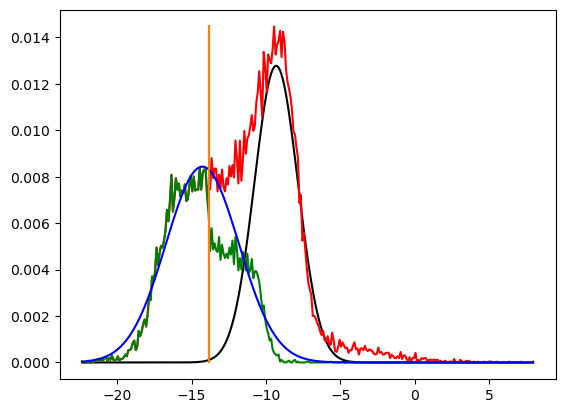

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14cc23780>

In [18]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
#PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

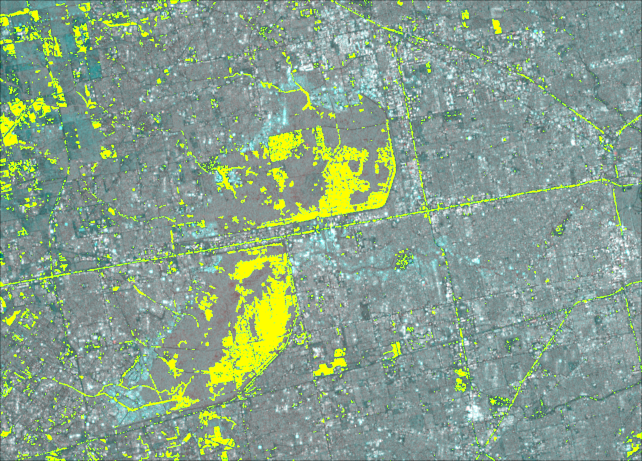

In [19]:
add_mask(imgVV,flood_mask,(1,2,0))

In [20]:
rg_thresholds

2-element Array{Float64,1}:
 23.61229341623544
 -1.0             

In [21]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

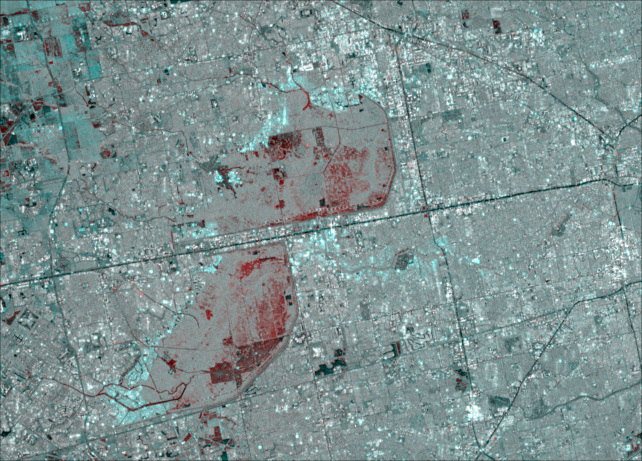

In [22]:
add_mask(imgVV,final_mask,(1,1,0))

## VH

In [23]:
co = VH[1][:,end:-1:1]
pre = VH[2][:,end:-1:1];

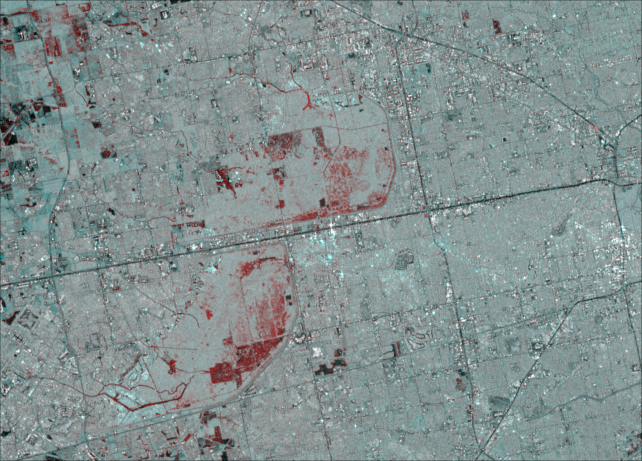

In [24]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [25]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [26]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


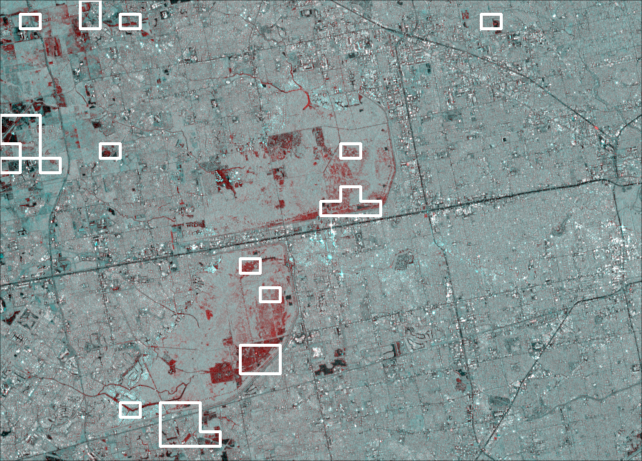

In [27]:
subset_edges = get_edges(bm_mask);
add_mask(imgVH,subset_edges,(1,1,1))

In [28]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;

In [29]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3)


Iterration : 1
x_i: [-20.725, -1.0], f_i: 0.00025905219152579486
dfdx: [0.0, 0.0]

Iterration : 2
x_i: [-20.725, -1.0], f_i: 0.00025905219152579486
dfdx: [-9.35063e-5, 0.0]
Step x, step_idx:4,  no_step: -2

Iterration : 3
x_i: [-11.3744, -1.0], f_i: 5.997684904711325e-5
dfdx: [0.0, 4.15774e-5]
Step x, step_idx:3,  no_step: -2

Iterration : 4
x_i: [-11.3744, -1.41577], f_i: 5.4752058425127414e-5
dfdx: [6.9308e-9, -1.46493e-5]
Step x, step_idx:2,  no_step: -2

Iterration : 5
x_i: [-11.3744, -1.40112], f_i: 5.438468488462387e-5
dfdx: [6.9308e-9, -2.9609e-6]
No change, Decrease delta, no_step: -1

Iterration : 6
x_i: [-11.3744, -1.40112], f_i: 5.438468488462387e-5
dfdx: [0.0, -2.9609e-6]
No change, Decrease delta, no_step: 0

Iterration : 7
x_i: [-11.3744, -1.40112], f_i: 5.438468488462387e-5
dfdx: [0.0, -2.9609e-6]
No change, Decrease delta, no_step: 1

Iterration : 8
x_i: [-11.3744, -1.40112], f_i: 5.438468488462387e-5
dfdx: [0.0, -2.9609e-6]
No change, Decrease delta, no_step: 2

Iterr

5.438468488462387e-5

In [30]:
thresholds3, f3

([-11.3744, -1.40112], 5.438468488462387e-5)

In [31]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-6.92989, -1.33909], 5.427491774094725e-5)

In [32]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-19.3275, 1.35918], 9.659869402989661e-5)

In [33]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx]

2-element Array{Float64,1}:
 -11.37437646582185  
  -1.4011245822873009

In [34]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [35]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

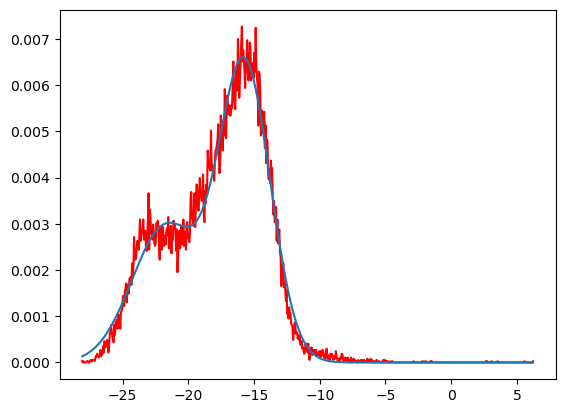

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14491e828>

In [36]:
PyPlot.figure()
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )


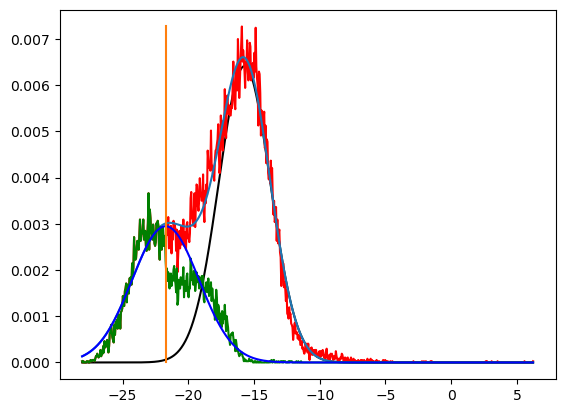

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14ac8cf60>

In [37]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

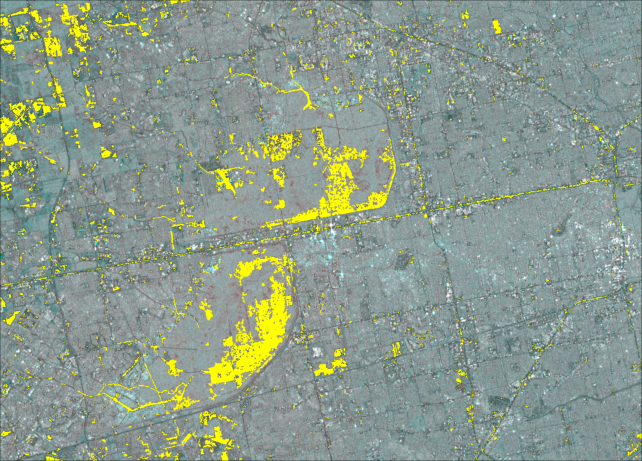

In [38]:
add_mask(imgVH,flood_mask,(1,1,0))

In [39]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

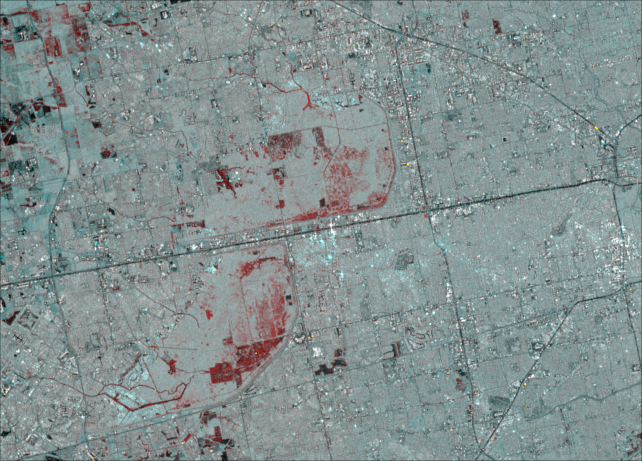

In [40]:
add_mask(imgVH,final_mask,(1,1,0))